In [1]:
import numpy as np
import pandas as pd
import os
import multiprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import erfc
import scipy
from sklearn.metrics import confusion_matrix

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
def get_scores(TN, FP, FN, TP):
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    return TNR, FPR, FNR, TPR

def chauvenet(array):
    mean = array.mean()           # Mean of incoming array
    stdv = array.std()            # Standard deviation
    N = len(array)                # Lenght of incoming array
    criterion = 1.0/(2*N)         # Chauvenet's criterion
    d = abs(array-mean)/stdv      # Distance of a value to mean in stdv's
    prob = erfc(d)                # Area normal dist.    
    return prob < criterion       # Use boolean array outside this function

In [3]:
picking_df = pd.read_csv('./picking_df.csv')
picking_df = picking_df.loc[:, ~picking_df.columns.str.contains('^Unnamed')]
picking_df

,worker_id,busket_id,product_id,weight,operation,label
0,1,3606,9,0.417402,PUT,False
1,0,9881,2,0.494019,PUT,False
2,1,5745,2,0.496973,PUT,False
3,0,9237,8,0.381270,PUT,False
4,0,8359,3,0.576675,PUT,False
...,...,...,...,...,...,...
160251,0,8784,-1,0.000000,END,False
160252,1,9604,3,0.589388,PUT,False
160253,1,9604,-1,0.000000,END,False
160254,1,8618,9,0.415455,PUT,False


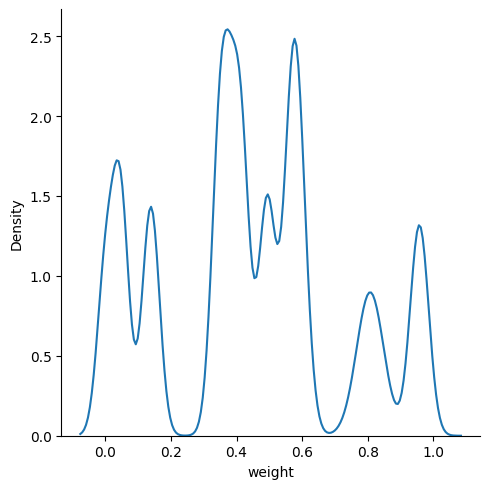

In [4]:
sns.displot(picking_df, x="weight", kind="kde")
plt.show()

/Users/sang-geon/git_reps/kurlyhackfesta2022/venv/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


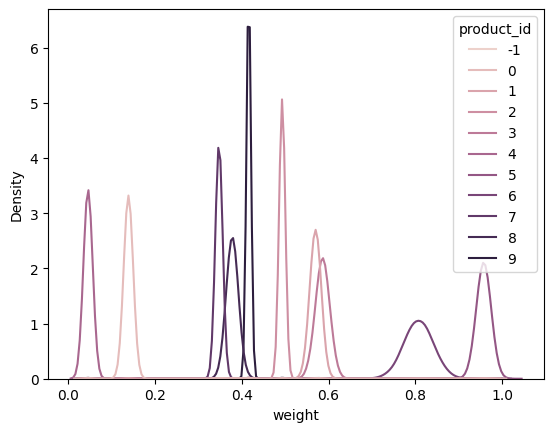

In [5]:
sns.kdeplot(data=picking_df, x="weight", hue="product_id")
plt.show()

In [6]:
product_id = 0

weights = picking_df[(picking_df['product_id'] == product_id) & (picking_df['operation'] == 'PUT')]['weight'].values
labels = picking_df[(picking_df['product_id'] == product_id) & (picking_df['operation'] == 'PUT')]['label'].values
weights, labels, np.sum(labels==True), weights.mean(), weights.std()

(array([0.13582888, 0.13400484, 0.13550669, ..., 0.12936874, 0.15070495,
        0.13721574]),
 array([False, False, False, ..., False, False, False]),
 317,
 0.14669646969037367,
 0.06320792342962323)

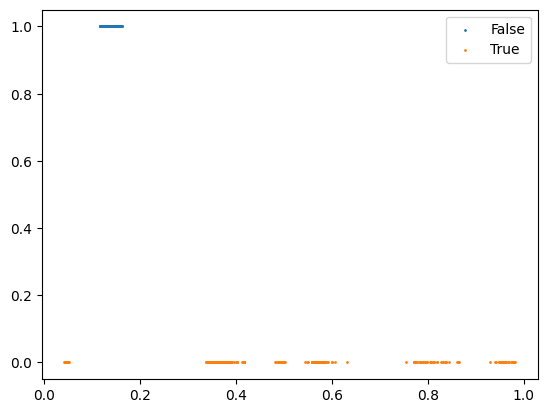

In [7]:
plt.scatter(weights[labels == False], np.ones_like(weights[labels == False]), s=1, label='False')
plt.scatter(weights[labels == True], np.zeros_like(weights[labels == True]), s=1, label='True')
#plt.xlim([0.11, 0.17])
plt.legend()
plt.show()

In [8]:
pred = chauvenet(weights)
tn, fp, fn, tp = confusion_matrix(labels, pred, labels=[0, 1]).ravel()
len(weights), np.sum(pred), np.sum(labels), np.sum(pred == labels) / len(weights), (tn, fp, fn, tp), get_scores(tn, fp, fn, tp)

(15021,
 287,
 317,
 0.9980027960854804,
 (14704, 0, 30, 287),
 (1.0, 0.0, 0.0946372239747634, 0.9053627760252366))

In [9]:
def test(weights, labels, window_size=-1):
  accs = []
  tnrs, fprs, fnrs, tprs = [], [], [], []

  preds, targets = [], []
  for t in range(len(weights)):
    pred = chauvenet(weights[0 if window_size == -1 else max(0, t + 1 - window_size):t + 1])
    preds.append(pred[-1])
    targets.append(labels[t])
    tn, fp, fn, tp = confusion_matrix(targets, preds, labels=[0, 1]).ravel()
    tnr, fpr, fnr, tpr = get_scores(tn, fp, fn, tp)
    acc = np.sum(np.array(preds) == np.array(targets)) / (t + 1)

    accs.append(acc)
    tnrs.append(tnr)
    fprs.append(fpr)
    fnrs.append(fnr)
    tprs.append(tpr)
    
  return accs, tnrs, fprs, fnrs, tprs

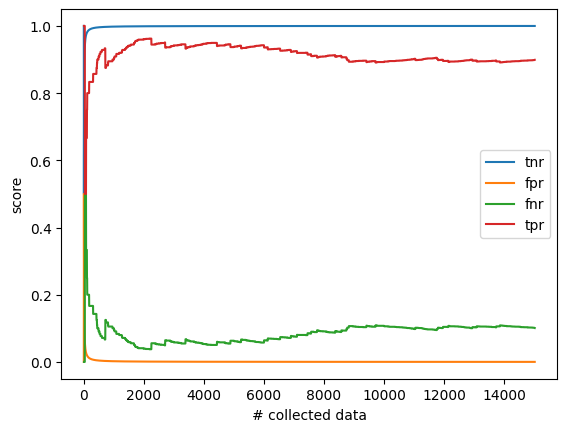

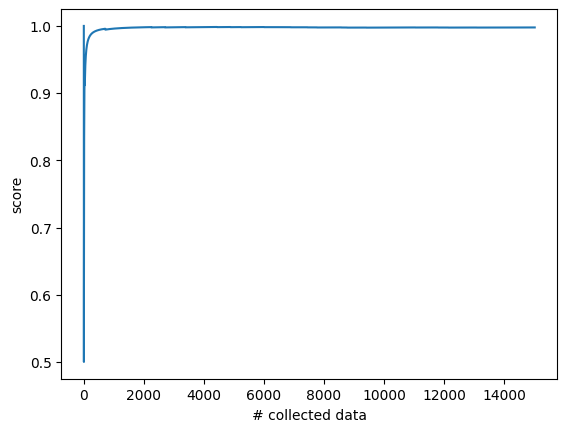

In [10]:
accs, tnrs, fprs, fnrs, tprs = test(weights, labels)

plt.plot(tnrs, label='tnr')
plt.plot(fprs, label='fpr')
plt.plot(fnrs, label='fnr')
plt.plot(tprs, label='tpr')
plt.xlabel('# collected data')
plt.ylabel('score')
plt.legend()
plt.show()

plt.plot(accs, label='accuracy')
plt.xlabel('# collected data')
plt.ylabel('score')
plt.show()

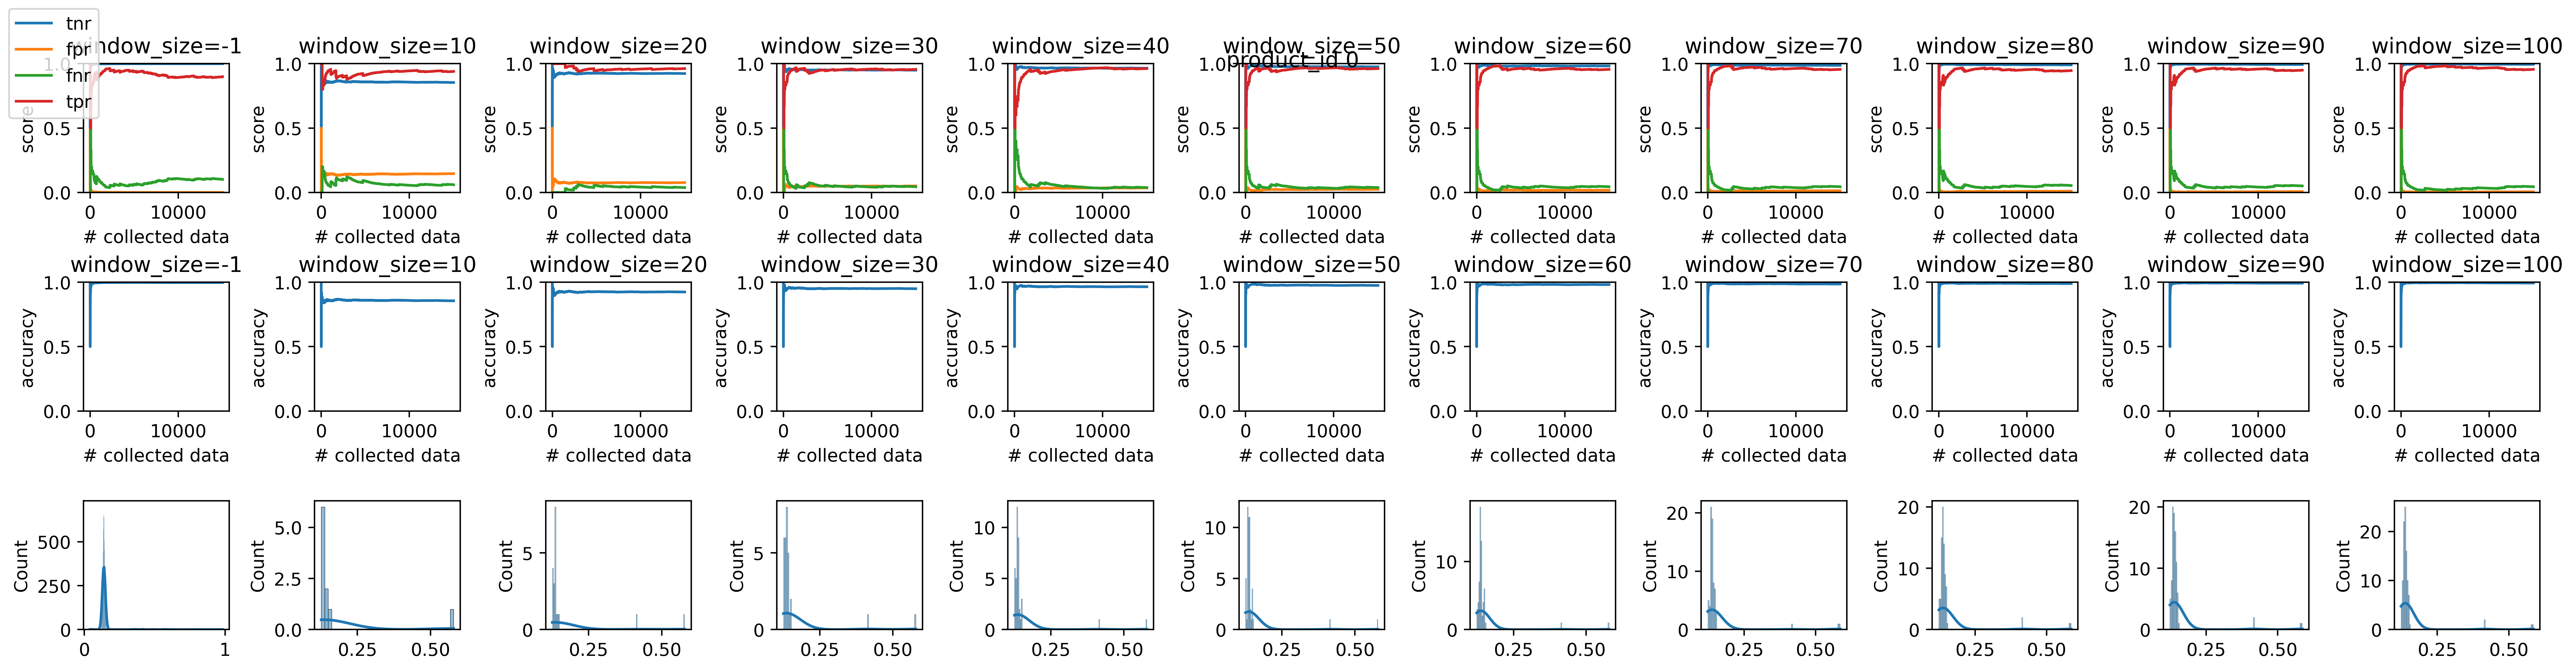

In [11]:
win_sizes = [-1] + list(range(10, 101, 10))

figure, axis = plt.subplots(3, len(win_sizes), dpi=500, figsize=(20,5))
figure.tight_layout(h_pad=3)
for idx, window_size in enumerate(win_sizes):

    accs, tnrs, fprs, fnrs, tprs = test(weights, labels, window_size=window_size)

    axis[0, idx].plot(tnrs, label='tnr')
    axis[0, idx].plot(fprs, label='fpr')
    axis[0, idx].plot(fnrs, label='fnr')
    axis[0, idx].plot(tprs, label='tpr')
    axis[0, idx].set_title(f'\nwindow_size={window_size}')
    axis[0, idx].set_xlabel('# collected data')
    axis[0, idx].set_ylabel('score')
    axis[0, idx].set_ylim([0, 1])

    axis[1, idx].plot(accs, label='accuracy')
    axis[1, idx].set_title(f'\nwindow_size={window_size}')
    axis[1, idx].set_xlabel('# collected data')
    axis[1, idx].set_ylabel('accuracy')
    axis[1, idx].set_ylim([0, 1])

    sns.histplot(weights[0 if window_size == -1 else -window_size:], kde=True, ax=axis[2, idx])

handles, plotlabels = axis[0, -1].get_legend_handles_labels()
figure.legend(handles, plotlabels, loc='upper left')
plt.suptitle(f'product_id {product_id}')
plt.show()

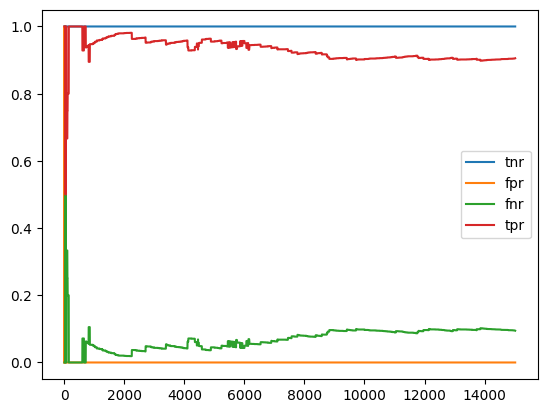

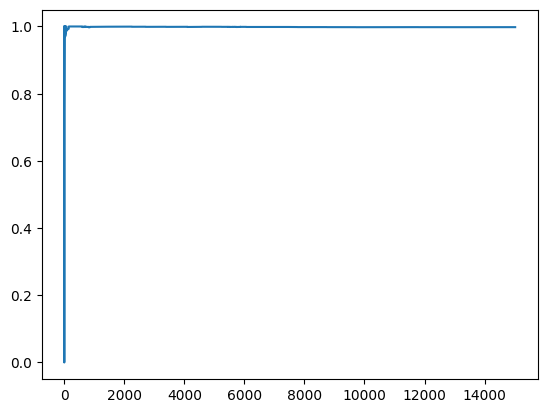

In [12]:
accs = []
tn_rates = []
fp_rates = []
fn_rates = []
tp_rates = []
for t in range(len(weights)):
  pred = chauvenet(weights[:t + 1])
  tn, fp, fn, tp = confusion_matrix(labels[:t + 1], pred, labels=[0, 1]).ravel()
  tnr, fpr, fnr, tpr = get_scores(tn, fp, fn, tp)
  acc = np.sum(pred == labels[:t + 1]) / (t + 1)
  accs.append(acc)
  tn_rates.append(tnr)
  fp_rates.append(fpr)
  fn_rates.append(fnr)
  tp_rates.append(tpr)

plt.plot(tn_rates, label='tnr')
plt.plot(fp_rates, label='fpr')
plt.plot(fn_rates, label='fnr')
plt.plot(tp_rates, label='tpr')
plt.legend()
plt.show()


plt.plot(accs, label='accuracy')
plt.show()

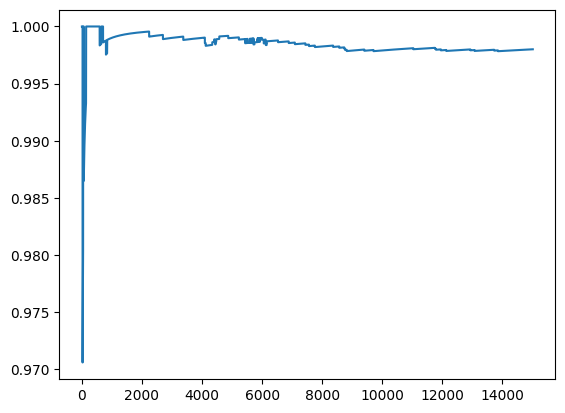

In [13]:
plt.plot(accs[10:], label='accuracy')
plt.show()